In [17]:
from __future__ import division
import pandas as pd
from string import digits
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
import hypertools as hyp
import scipy
import numpy as np
import os
import sys

%matplotlib inline

# Import lesson and question data

In [2]:
# Four forces
forces_video_df = pd.read_csv('../video transcript analysis/fourforcesdiced.tsv', 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])
forces_video_samples = forces_video_df[0].tolist()

In [3]:
# birth of stars
bos_video_df = pd.read_csv('../video transcript analysis/birthofstarsdiced.tsv', 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])
bos_video_samples = pd.Series(bos_video_df[0]).tolist()

In [78]:
# questions
infile = open("../data analysis/astronomyquestions.tsv", "r")

parts = []
for line in infile.read().split("\n"):
    parts.append(line.split("\t"))
    
infile.close()

parts.pop() # remove empty list at end

questions_df = pd.DataFrame(parts)
questions_df = questions_df.iloc[:,:3]
    
gen_questions_samples = questions_df[questions_df[1]=='0'][2].tolist()
forces_questions_samples = questions_df[questions_df[1]=='1'][2].tolist()
bos_questions_samples = questions_df[questions_df[1]=='2'][2].tolist()

In [25]:
n_subjects = len(os.listdir(answers_dir))
n_questions = 15 # 30 total, 15 per video

# Model lessons and questions

In [5]:
vec_params = {
    'max_df': 0.95,
    'min_df': 2,
    'max_features': 500,
    'stop_words': 'english'
}

lda_params = {
    'n_topics': 20,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [115]:
def get_acc_answers(answers_df, subject, video, sort=False):
    """
    Function that matches correct answers to corresponding question
    """
    
    df = answers_df[answers_df.participantID==subject]
    if len(df) == 0:
        print("Subject {} has no data".format(subject))
        return
    df = df[df.video==video]
    
    if sort:
        return df.sort_values('qID')['correct?'].tolist()
    else:
        return df['correct?'].tolist()
    

In [56]:
def reconstruct_trace(video_model, questions_model, acc):
    """
    Function that reconstructs memory trajectory based on video model and a set of correctly answered questions
    """
    
    def normalize(x):
        xs = x - np.min(x)
        return np.divide(xs, np.max(xs))
    
    def z2r(z):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    
    def r2z(r):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    def symmetric_KL(a, b, c=.00000000001):
        return np.divide(entropy(a+c,b+c)+entropy(b+c,a+c), 2)

    # compute timepoints by questions correlation matrix
    wz = 1-scipy.spatial.distance.cdist(video_model, questions_model, symmetric_KL)
    
    # add the minimum value
    wz-=np.min(wz)
    
    # divide by the max value
    wz/=np.max(wz)
    
    # sum over columns
    a = np.sum(wz, axis=1)
 
    # sum over columns for correct answers
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    
    # divide b by a
    ba = np.array(np.divide(b,a), ndmin=2)
    
    # weight the model
    return video_model*ba.T

In [156]:
def pcorrect_msd(video_topics, questions_topics, n_questions, n_perms, p_correct = [0, .05, .25, .50, .75, .95, 1]):
    """
    Function that computes the MSD between video and question models as a function of p(correct answer)
    """
    
    dist = []
    for pc in p_correct:
        dists = []
        for perm in range(n_perms):
            acc = np.random.binomial(1, pc, n_questions).astype(int)
            recon = reconstruct_trace(video_topics, questions_topics, acc)
            dists.append(np.mean(video_topics-recon)**2)
        dist.append(dists)
    return dist

# Run functions on video and question data

## Four Forces

In [6]:
sys.path.append("../data analysis")
from model_topics import model_topics

forces_v_topics, forces_q_topics = model_topics(forces_video_samples,forces_questions_samples,lda_params=lda_params,vec_params=vec_params)

Modeling Topics!


/usr/local/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
../data analysis/model_topics.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  video_topics = pd.DataFrame(video_topics).rolling(25).mean().loc[25:,:].as_matrix()


In [126]:
df = pd.read_csv('../graded_answers/Graded_results_19s.csv',index_col=0)
n_subjects = max(df["participantID"].unique())
forces_sub_correct = [get_acc_answers(df, sub+1, 1, sort=True) for sub in range(n_subjects)]
forces_sub_correct = [i for i in forces_sub_correct if i] #remove nones
n_subjects = len(forces_sub_correct)

Subject 4 has no data
Subject 6 has no data
Subject 26 has no data
Subject 36 has no data


In [127]:
forces_traces_by_sub = {sub : reconstruct_trace(forces_v_topics, forces_q_topics, forces_sub_correct[sub]) 
                        for sub in range(n_subjects)}

# Figures

## Four Forces

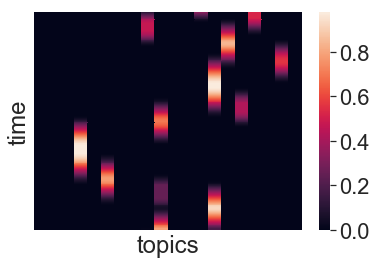

In [11]:
# video topic proportions matrix
sns.set_style('ticks')
sns.set(font_scale=2)

ax = sns.heatmap(pd.DataFrame(forces_v_topics), yticklabels=False, xticklabels=False, vmin=0)#, cmap=sns.diverging_palette(300, 20, as_cmap=True))
plt.xlabel('topics')
plt.ylabel('time')
plt.show()
#ax.get_figure().savefig('/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/forces_video_top_props.pdf')


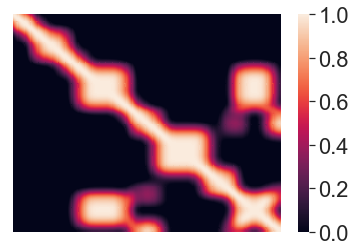

In [20]:
# video model temporal structure
ax = sns.heatmap(pd.DataFrame(forces_v_topics).T.corr(), yticklabels=False, xticklabels=False, vmin=0)#, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()
ax.get_figure().savefig('/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/forces_video_corrmat.pdf')


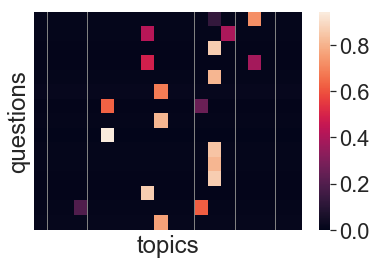

In [21]:
# questions topic proportions matrix
ax = sns.heatmap(pd.DataFrame(forces_q_topics), yticklabels=False, xticklabels=False, vmin=0, linewidths=.001, linecolor='gray')# cmap=sns.diverging_palette(220, 20, as_cmap=True),
plt.xlabel('topics')
plt.ylabel('questions')
plt.show()
ax.get_figure().savefig('/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/forces_questions_top_props.pdf')


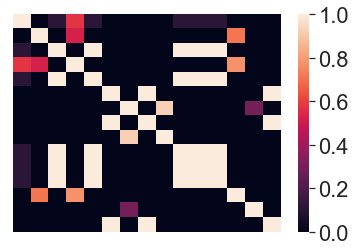

In [22]:
# questions model temporal structure
ax = sns.heatmap(pd.DataFrame(forces_q_topics).T.corr(), yticklabels=False, xticklabels=False, vmin=0)#, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()
ax.get_figure().savefig('/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/forces_questions_corrmat.pdf')


/usr/local/lib/python3.7/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/forces_vid_ques_topic_trajectories.pdf'

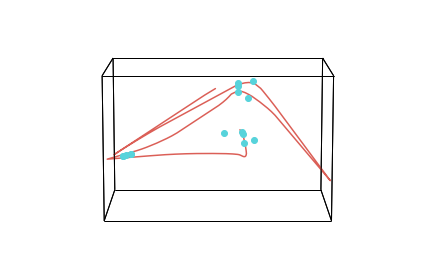

In [7]:
# 3D plot of video topic trajectory and question topics
_ = hyp.plot([pd.DataFrame(forces_v_topics), pd.DataFrame(forces_q_topics)], ['-','o'], azim=90,
            save_path = '/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/forces_vid_ques_topic_trajectories.pdf')


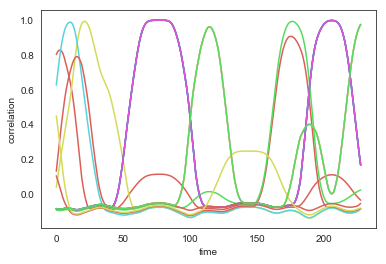

In [10]:
# correlations between topic vectors for each sliding window of video and each question
sns.set_palette('hls')
sns.set_style('white')
plt.tight_layout()
ax = plt.plot(1-scipy.spatial.distance.cdist(forces_v_topics, forces_q_topics, 'correlation'))
plt.ylabel('correlation')
plt.xlabel('time')
#plt.savefig('/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/\
#forces_dynamic_v_q_corr.pdf', bbox_inches='tight')
plt.show()


0


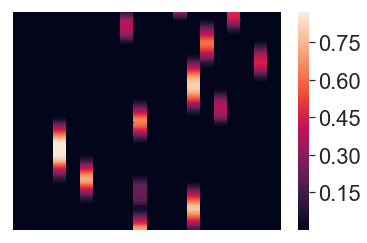

1


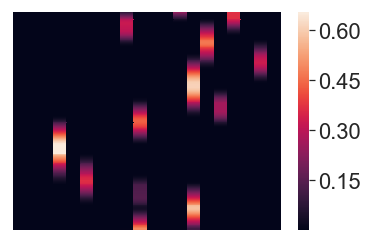

2


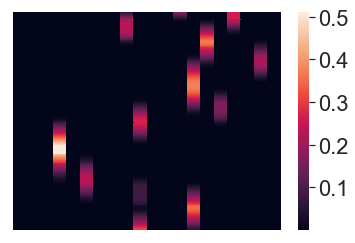

3


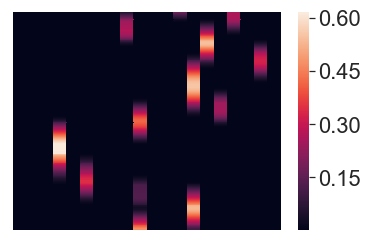

4


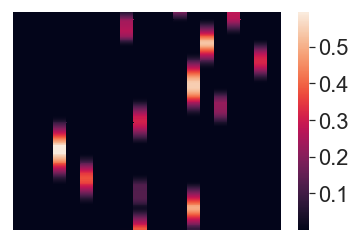

5


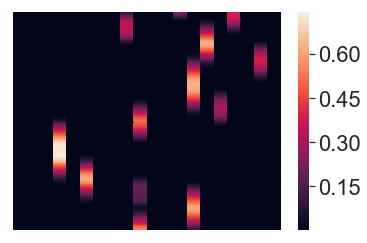

6


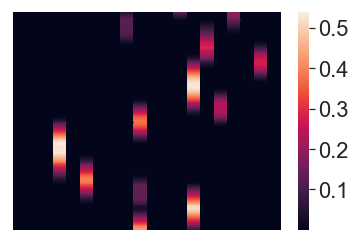

7


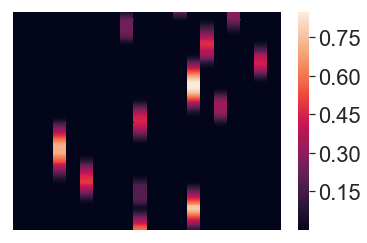

8


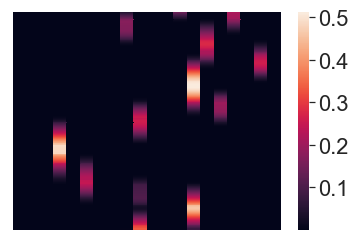

9


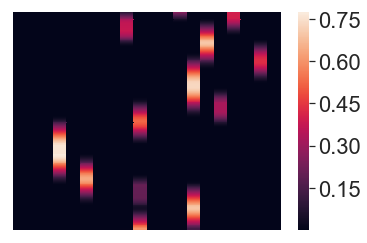

10


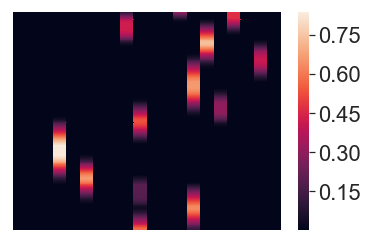

11


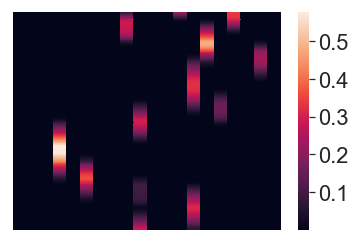

12


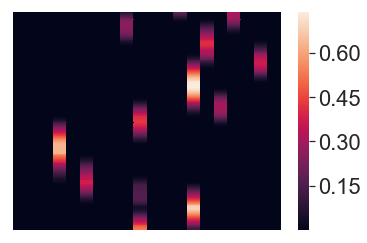

13


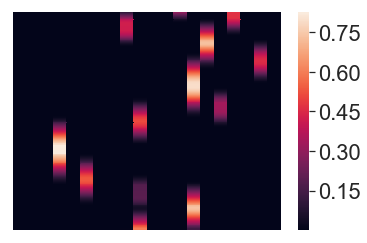

14


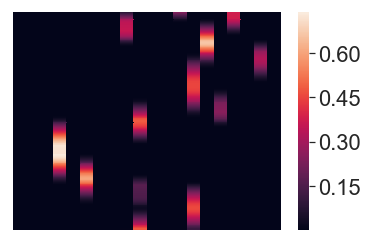

15


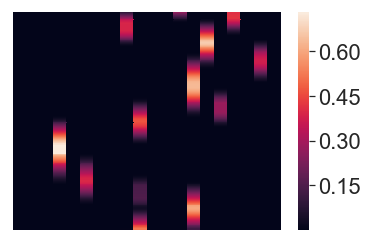

16


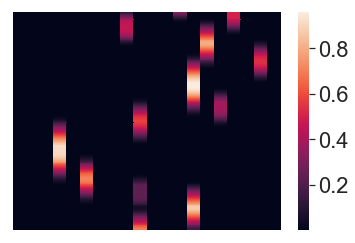

17


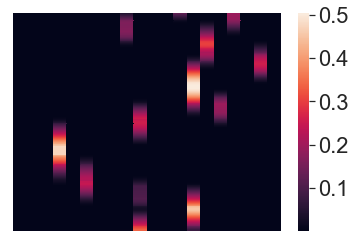

18


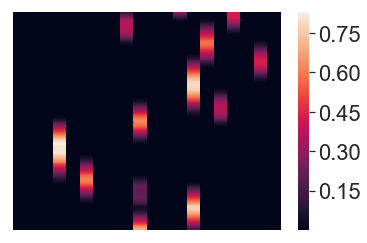

19


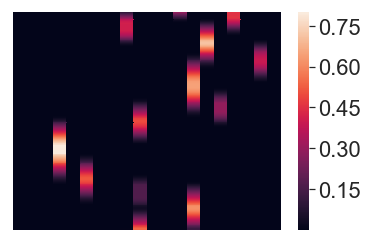

20


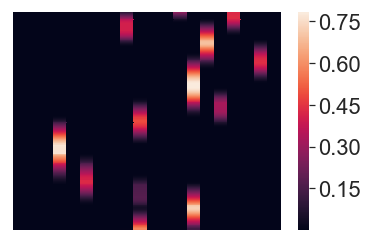

21


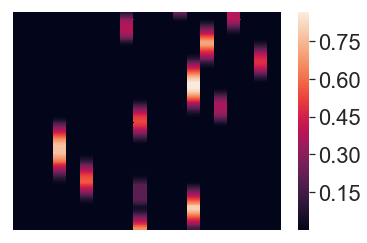

22


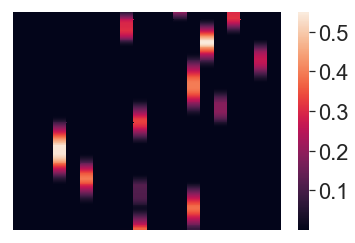

23


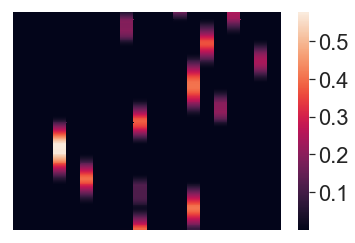

24


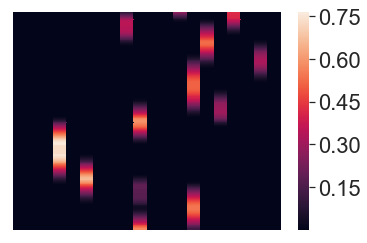

25


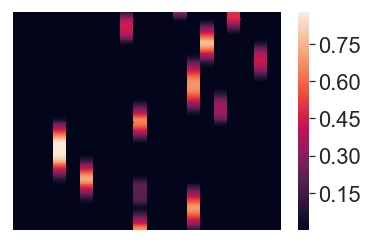

26


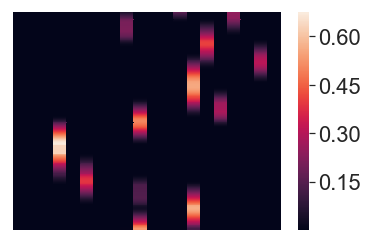

27


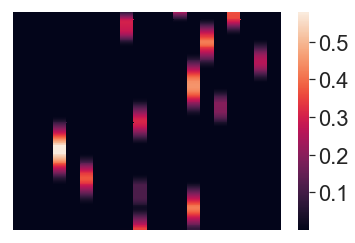

28


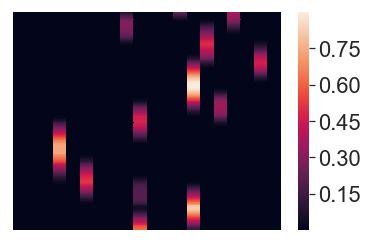

29


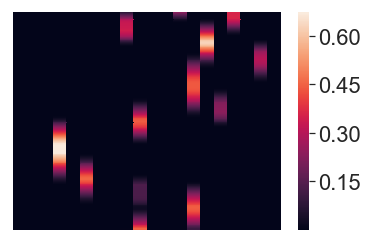

30


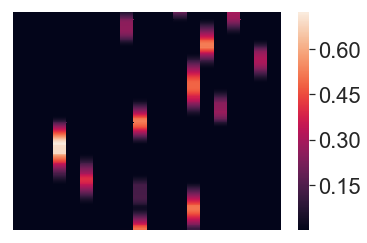

31


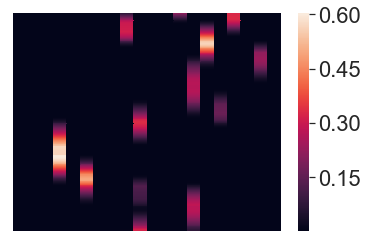

32


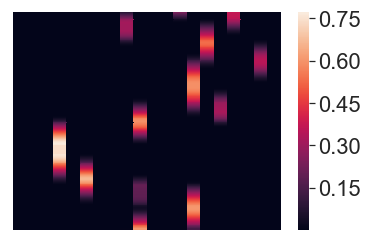

33


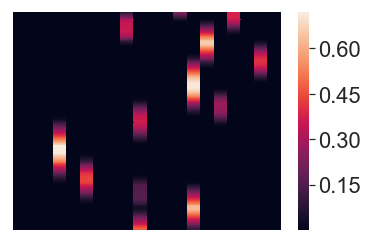

34


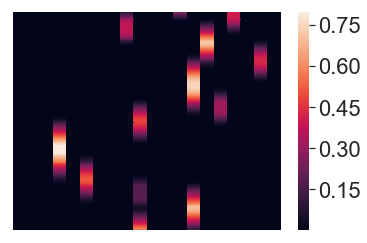

35


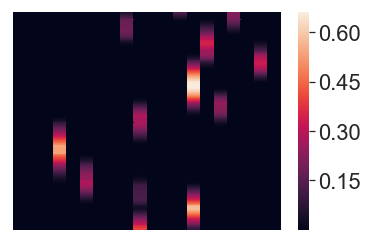

In [128]:
# reconstructed memory trace topics proportions matrix (by subject)
for sub, trace in forces_traces_by_sub.items():
    print(sub)
    ax = sns.heatmap(trace, xticklabels=False, yticklabels=False)
    plt.show()
    #ax.get_figure().savefig('/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/\
#traces_by_subject/forces_mem_trace_%s.pdf' % sub)


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


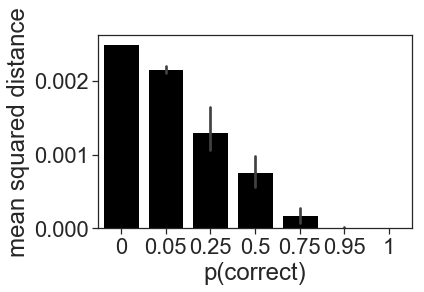

In [157]:
# MSD between video and question models as function of p(correct answer)
n_questions = 15
forces_msd_pcorrect = pcorrect_msd(forces_v_topics, forces_q_topics, n_questions, 5)
sns.set_style('ticks')
ax = plt.subplot()
sns.barplot(data=forces_msd_pcorrect, color='black', ax=ax)
ax.set_xticklabels([0, .05, .25, .50, .75, .95, 1])
ax.set_ylim(0.)
ax.set_xlabel('p(correct)')
ax.set_ylabel('mean squared distance')
plt.tight_layout()
#ax.get_figure().savefig('/Users/paxtonfitzpatrick/Documents/Dartmouth/CDL/efficient-learning-khan/figures/\
#msd_pcorrect_by_subject/trace_msd_%s.pdf' % sub)
plt.show()


0


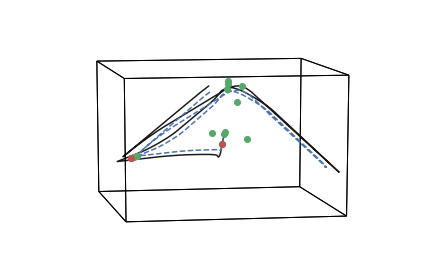

1


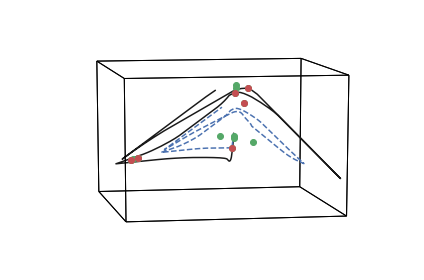

2


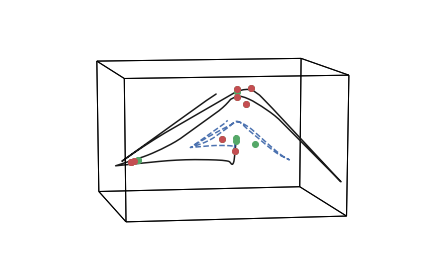

3


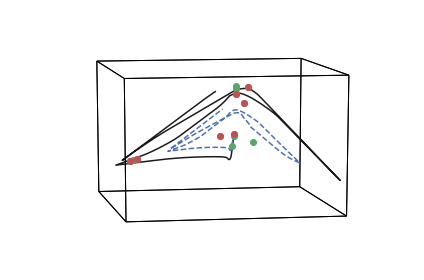

4


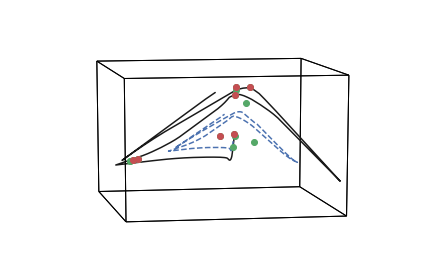

5


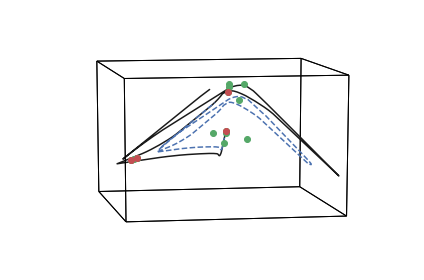

6


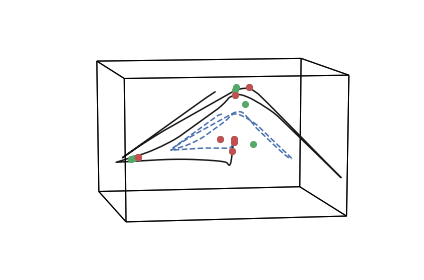

7


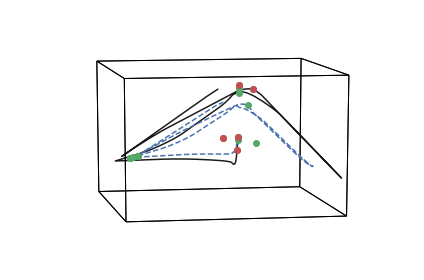

8


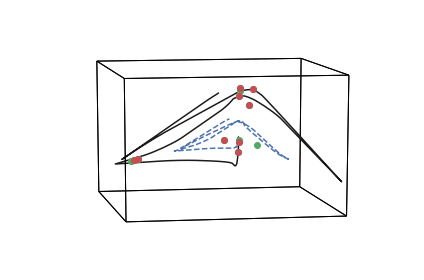

9


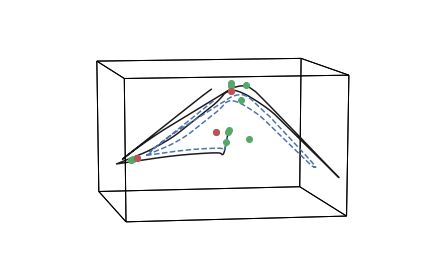

10


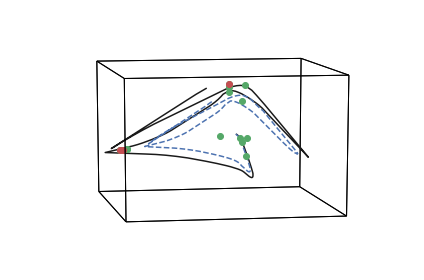

11


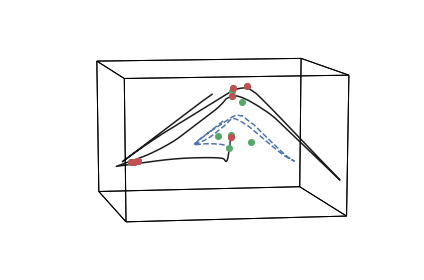

12


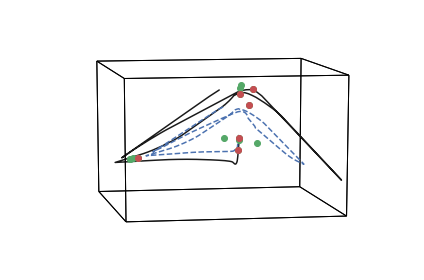

13


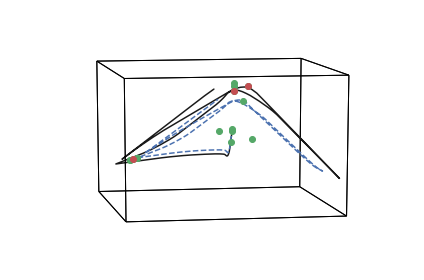

14


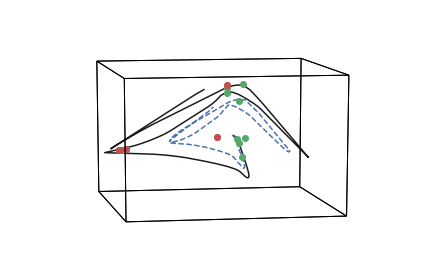

15


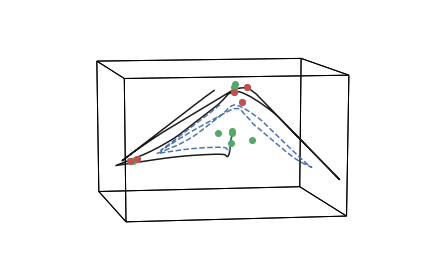

16


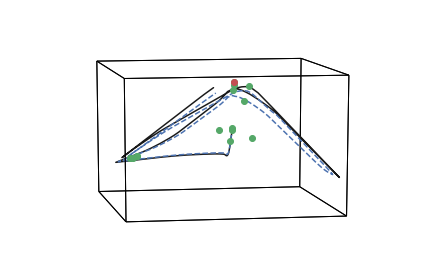

17


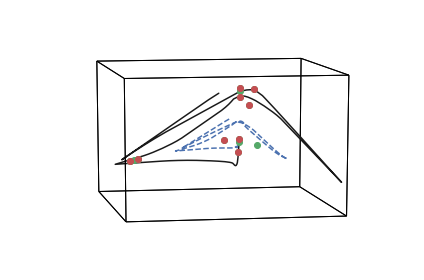

18


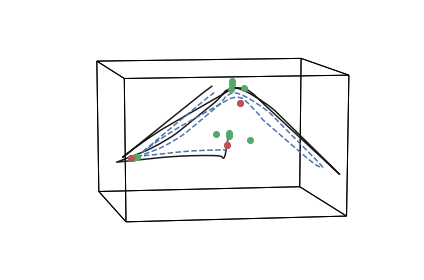

19


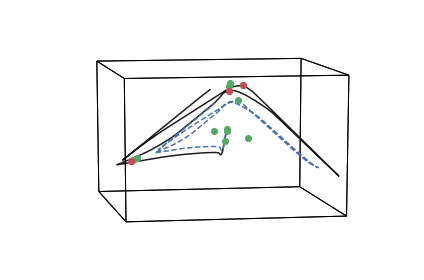

20


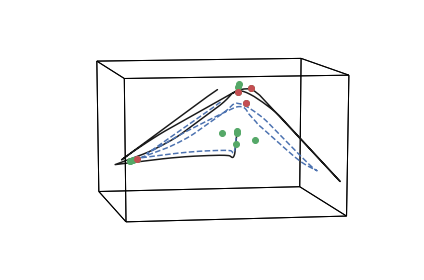

21


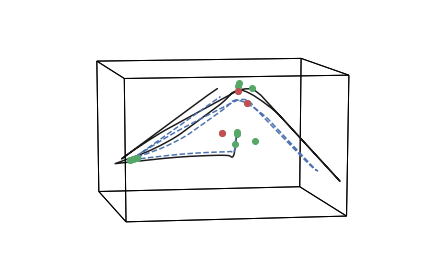

22


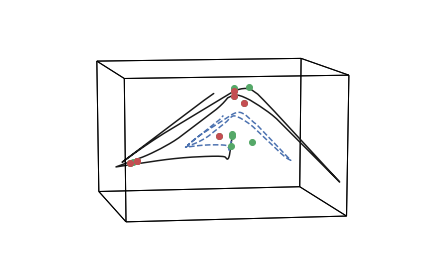

23


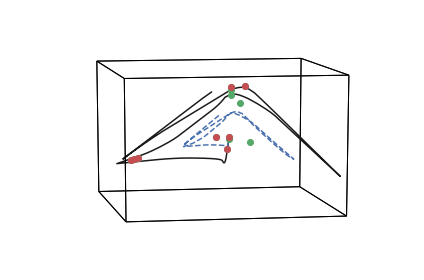

24


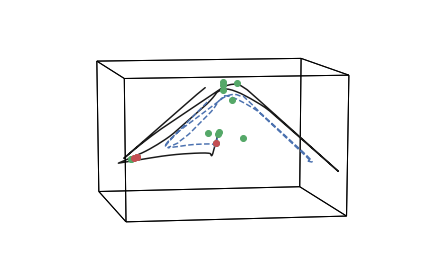

25


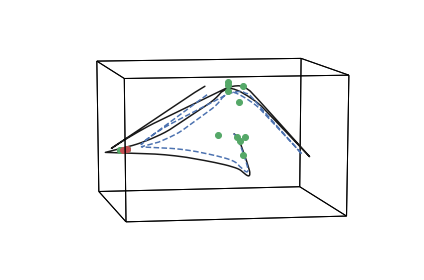

26


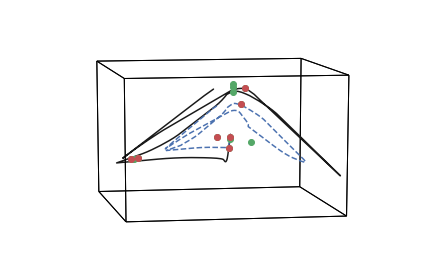

27


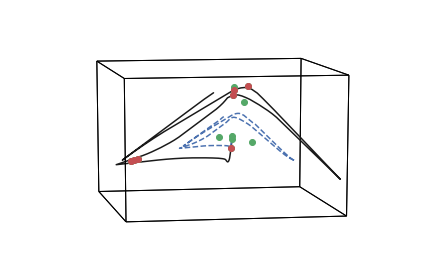

28


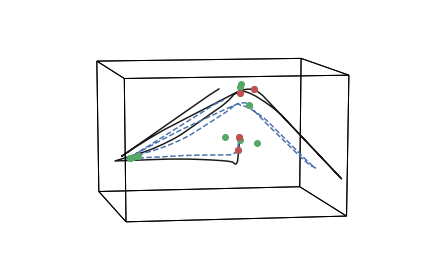

29


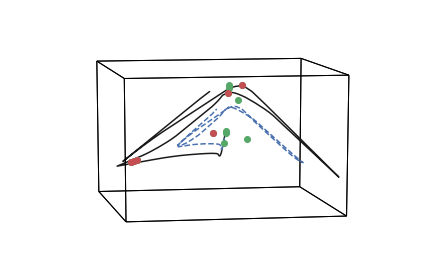

30


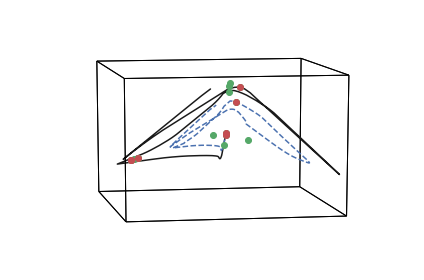

31


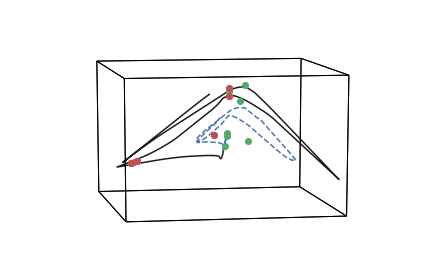

32


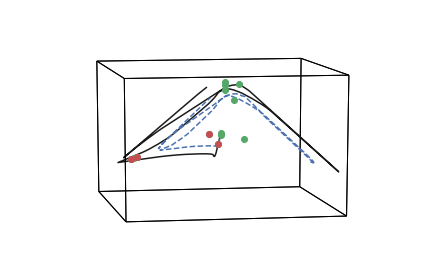

33


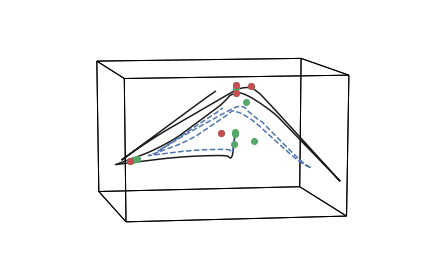

34


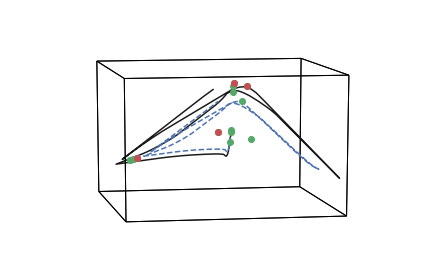

35


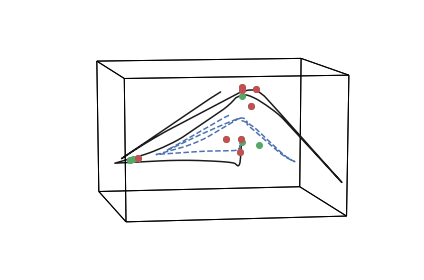

In [192]:
for s in range(n_subjects):
    print(s)
    _ = hyp.plot([forces_v_topics, forces_traces_by_sub[s], forces_q_topics, 
                  np.array(pd.DataFrame(forces_q_topics)[[x==0 for x in forces_sub_correct[s]]].values)], 
                 ['k-','b--', 'go', 'ro'], azim=80)